C:\Users\Pratik\AppData\Local\Temp\ipykernel_21200\3703903572.py:115: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


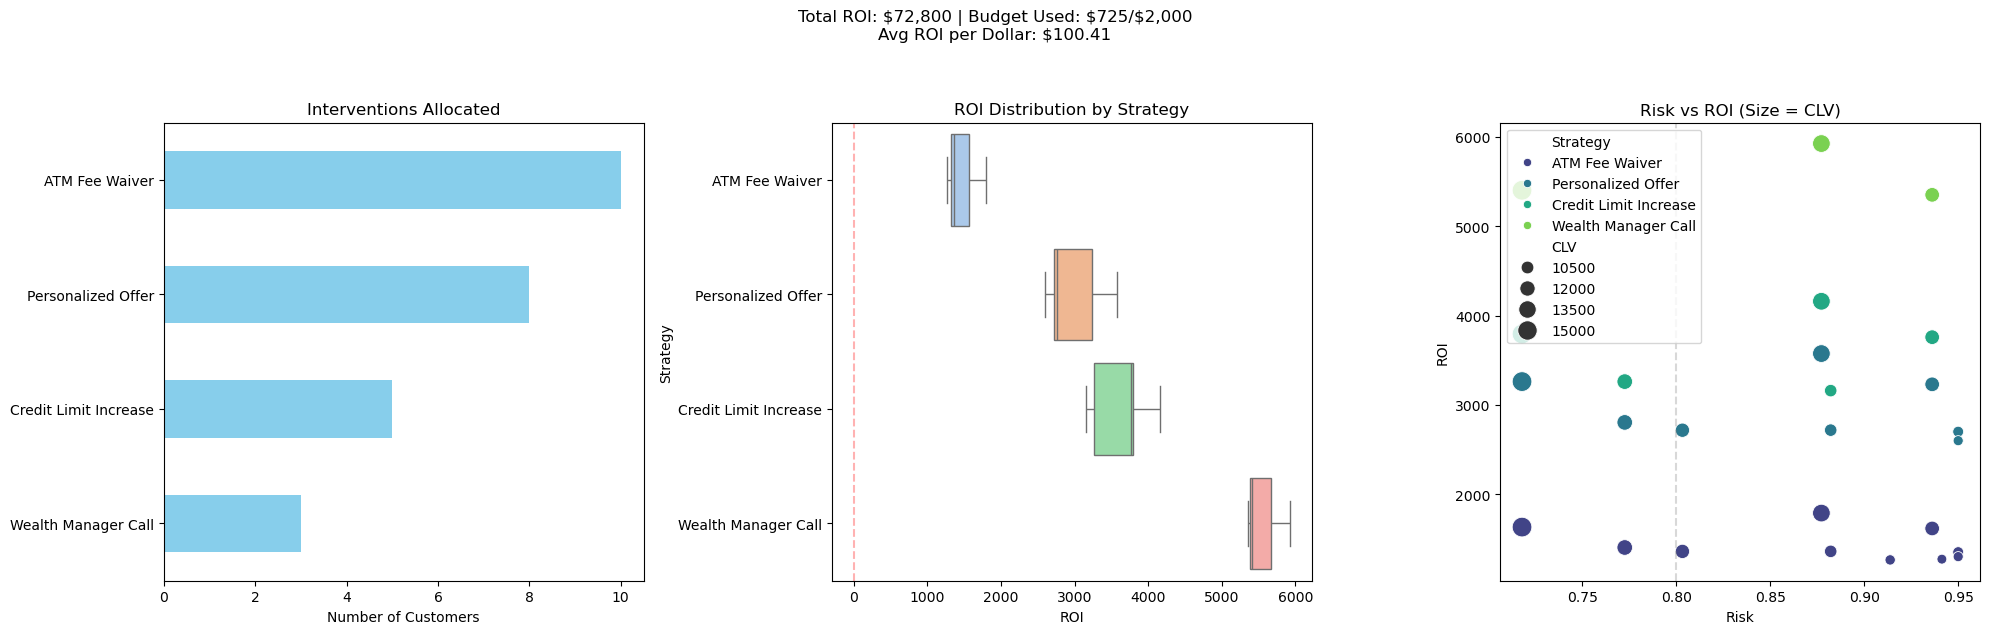


💎 Top 5 Value Interventions:


,CustomerID,Strategy,ROI,Cost,Risk,CLV,ROI_Ratio
76,15714241,Wealth Manager Call,"$5,926",75,87.7%,"$13,683",79.0x
176,15620756,Wealth Manager Call,"$5,403",75,71.8%,"$15,264",72.0x
0,15793688,Wealth Manager Call,"$5,352",75,93.6%,"$11,595",71.4x
77,15714241,Credit Limit Increase,"$4,161",40,87.7%,"$13,683",104.0x
177,15620756,Credit Limit Increase,"$3,795",40,71.8%,"$15,264",94.9x


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display


class BankInterventionOptimizer:
    def __init__(self, customer_data):
        self.data = customer_data.copy()
        self._preprocess_data()
        
        # Validated strategy parameters (cost, risk_reduction, max_usage)
        self.strategies = {
            "Wealth Manager Call": (75, 0.50, 3),
            "Credit Limit Increase": (40, 0.35, 5), 
            "Personalized Offer": (25, 0.30, 8),
            "ATM Fee Waiver": (10, 0.15, 10)
        }
    
    def _preprocess_data(self):
        """Ensure realistic probabilities"""
        self.data['churn_prob'] = np.minimum(self.data['churn_prob'], 0.95)
        self.data['CLV'] = self.data.apply(self._calculate_clv, axis=1)
    
    def _calculate_clv(self, customer):
        """Conservative CLV estimation"""
        monthly_profit = customer['Balance'] * 0.0045  # Reduced from 0.5%
        retention_rate = 1 - customer['churn_prob']
        return monthly_profit * 12 * min(1 / (1 - retention_rate), 10)  # Cap at 10 years
    
    def optimize(self, customer_ids, max_budget=2000):
        """Greedy optimization with strategy limits"""
        candidates = []
        for cid in customer_ids:
            customer = self.data[self.data['CustomerId'] == cid].iloc[0]
            for strat, (cost, risk_red, _) in self.strategies.items():
                value_saved = customer['CLV'] * risk_red * customer['churn_prob']
                roi = min(value_saved - cost, customer['CLV'] * 0.9)  # ROI cap
                candidates.append({
                    'CustomerID': cid,
                    'Strategy': strat,
                    'ROI': roi,
                    'Cost': cost,
                    'Risk': customer['churn_prob'],
                    'CLV': customer['CLV']
                })
        
        # Sort by ROI efficiency (ROI/Cost ratio)
        candidates_df = pd.DataFrame(candidates)
        candidates_df['ROI_Ratio'] = candidates_df['ROI'] / candidates_df['Cost']
        candidates_df = candidates_df.sort_values('ROI_Ratio', ascending=False)
        
        # Greedy allocation
        allocations = []
        strategy_counts = {s:0 for s in self.strategies}
        remaining_budget = max_budget
        
        for _, row in candidates_df.iterrows():
            if remaining_budget < row['Cost']:
                continue
            if strategy_counts[row['Strategy']] >= self.strategies[row['Strategy']][2]:
                continue
                
            allocations.append(row)
            strategy_counts[row['Strategy']] += 1
            remaining_budget -= row['Cost']
            
            if remaining_budget < min(v[0] for v in self.strategies.values()):
                break
        
        return {
            'allocations': pd.DataFrame(allocations),
            'strategy_counts': strategy_counts,
            'total_roi': sum(a['ROI'] for a in allocations),
            'budget_used': max_budget - remaining_budget
        }

# Load and prepare data
df = pd.read_csv("../data/predictions/data_with_predictions.csv")
high_risk = df[df['churn_prob'] > 0.7].sample(
    n=50, 
    weights=df['churn_prob'] * df['Balance']  # Weight by both risk and value
)['CustomerId'].values

# Run optimization
optimizer = BankInterventionOptimizer(df)
results = optimizer.optimize(high_risk)

# %% [code]
def visualize_allocations(results):
    alloc = results['allocations']
    
    # Strategy distribution
    strat_dist = pd.DataFrame.from_dict(
        results['strategy_counts'], 
        orient='index', 
        columns=['Count']
    )
    
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
    
    # Plot 1: Strategy counts
    strat_dist.sort_values('Count').plot(
        kind='barh', 
        ax=ax1, 
        color='skyblue',
        legend=False
    )
    ax1.set_title("Interventions Allocated")
    ax1.set_xlabel("Number of Customers")
    
    # Plot 2: ROI by strategy
    sns.boxplot(
        data=alloc,
        y='Strategy',
        x='ROI',
        ax=ax2,
        palette='pastel'
    )
    ax2.set_title("ROI Distribution by Strategy")
    ax2.axvline(0, color='red', linestyle='--', alpha=0.3)
    
    # Plot 3: Risk vs ROI
    sns.scatterplot(
        data=alloc,
        x='Risk',
        y='ROI',
        hue='Strategy',
        size='CLV',
        sizes=(50, 200),
        ax=ax3,
        palette='viridis'
    )
    ax3.set_title("Risk vs ROI (Size = CLV)")
    ax3.axvline(0.8, color='grey', linestyle='--', alpha=0.3)
    
    plt.suptitle(
        f"Total ROI: ${results['total_roi']:,.0f} | "
        f"Budget Used: ${results['budget_used']:,.0f}/$2,000\n"
        f"Avg ROI per Dollar: ${results['total_roi']/results['budget_used']:.2f}",
        y=1.05
    )
    plt.tight_layout()
    plt.show()
    
    # Display top recommendations
    print("\n💎 Top 5 Value Interventions:")
    display(
        alloc.sort_values('ROI', ascending=False)
        .head(5)
        .style.format({
            'ROI': '${:,.0f}',
            'CLV': '${:,.0f}',
            'Risk': '{:.1%}',
            'ROI_Ratio': '{:.1f}x'
        })
    )

visualize_allocations(results)

In [92]:
results['allocations'].to_csv(
    "../output/retention_recommendations.csv",
    float_format="%.2f",
    index=False
)

In [96]:
# Expected performance metrics
print(f"""\
Expected Results:
- Customer Retention: {len(results['allocations'])} high-risk customers targeted
- Budget Utilization: ${results['budget_used']} of $2000 ({results['budget_used']/2000:.0%})
- Average ROI: ${results['total_roi']/len(results['allocations']):.0f} per customer
""")

Expected Results:
- Customer Retention: 26 high-risk customers targeted
- Budget Utilization: $725 of $2000 (36%)
- Average ROI: $2601 per customer

